# ARIMA model

- Create one model per `air_store_id`
- The prediction from ARIMA model will be purely based on the number of visitors in the past

## Load packages and data

In [1]:
import numpy as np
import pandas as pd
import pmdarima as pm
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
from sklearn.metrics import mean_squared_log_error


In [2]:
data = {
    'a_reserve': pd.read_csv('data/air_reserve.csv', parse_dates=['reserve_datetime', 'visit_datetime']),
    'h_reserve': pd.read_csv('data/hpg_reserve.csv', parse_dates=['reserve_datetime', 'visit_datetime']),
    'a_store': pd.read_csv('data/air_store_info.csv'),
    'h_store': pd.read_csv('data/hpg_store_info.csv'),
    'id_relation': pd.read_csv('data/store_id_relation.csv'),
    'a_visit': pd.read_csv('data/air_visit_data.csv', parse_dates=['visit_date']),
    'date_info': pd.read_csv('data/date_info.csv', parse_dates=['calendar_date']),
    'sample_df': pd.read_csv('data/sample_submission.csv'),
    'sample_df_new': pd.read_csv('data/to_be_predicted.csv', parse_dates=['date'])
}

## Prepare data

In [3]:
data['a_visit'].head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [4]:
visitors = data['a_visit'].pivot(index='visit_date', columns='air_store_id', values='visitors')

In [5]:
visitors.head()

air_store_id,air_00a91d42b08b08d9,air_0164b9927d20bcc3,air_0241aa3964b7f861,air_0328696196e46f18,air_034a3d5b40d5b1b1,air_036d4f1ee7285390,air_0382c794b73b51ad,air_03963426c9312048,air_04341b588bde96cd,air_049f6d5b402a31b2,...,air_fd6aac1043520e83,air_fdc02ec4a3d21ea4,air_fdcfef8bd859f650,air_fe22ef5a9cbef123,air_fe58c074ec1445ea,air_fea5dc9594450608,air_fee8dcf4d619598e,air_fef9ccb3ba0da2f7,air_ffcc2d5087e1b476,air_fff68b929994bfbd
visit_date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,...,NaN,NaN,NaN,21.0,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,37.0,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-03,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-04,NaN,NaN,9.0,NaN,NaN,NaN,NaN,62.0,23.0,NaN,...,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,NaN,NaN,17.0,NaN,NaN,NaN,NaN,30.0,35.0,NaN,...,36.0,NaN,NaN,NaN,32.0,NaN,NaN,NaN,NaN,NaN


### Fill NaNs

In [6]:
visitors.isna().sum().sort_values()

air_store_id
air_5c817ef28f236bdf      1
air_36bcf77d3382d36e      2
air_a083834e7ffe187e      2
air_d97dabf7aae60da5      2
air_60a7057184ec7ec7      3
                       ... 
air_1c0b150f9e696a5f    427
air_a17f0778617c76e2    431
air_789103bf53b8096b    437
air_a9a380530c1e121f    438
air_900d755ebd2f7bbd    458
Length: 829, dtype: int64

In [7]:
visitors['dow'] = visitors.index.dayofweek

In [8]:
# TODO: concat and stack at the bottom instead of doing inplace=True

In [9]:
# fill nan with the mean of the each day of the week
for day in range(0, 7):
    if day == 0:
        visitors_new = visitors[visitors.dow == day].fillna(visitors[visitors.dow == day].mean())
    else:
        na_filled = visitors[visitors.dow == day].fillna(visitors[visitors.dow == day].mean())
        visitors_new = pd.concat([visitors_new, na_filled], axis=0)
    print(f'day: {day}, # of restaurants where mean is NaN: {visitors[visitors.dow == day].mean().isna().sum()}')

day: 0, # of restaurants where mean is NaN: 14
day: 1, # of restaurants where mean is NaN: 2
day: 2, # of restaurants where mean is NaN: 3
day: 3, # of restaurants where mean is NaN: 1
day: 4, # of restaurants where mean is NaN: 2
day: 5, # of restaurants where mean is NaN: 4
day: 6, # of restaurants where mean is NaN: 36


In [10]:
visitors_new.isna().sum().sort_values()

air_store_id
air_00a91d42b08b08d9      0
air_a38f25e3399d1b25      0
air_a41b032371a63427      0
air_a49f1cf0634f13e5      0
air_a510dcfe979f09eb      0
                       ... 
air_cd4b301d5d3918d8    137
air_747f375eb3900e1e    137
air_105a7954e32dba9b    137
air_47beaffd3806c979    137
air_a9a380530c1e121f    205
Length: 830, dtype: int64

In [11]:
visitors_new = visitors_new.sort_index()

In [12]:
dow_na = dict()
for i in range(0,7):
    temp = visitors_new[visitors_new.dow==i].isna().sum()
    dow_na[i] = temp[temp.values > 0].sort_values()
    print(dow_na[i])

air_store_id
air_229d7e508d9f1b5e    68
air_26f10355d9b4d82a    68
air_68147db09287bf74    68
air_6d64dba2edd4fc0c    68
air_7fbf7649eb13ad9b    68
air_900d755ebd2f7bbd    68
air_9cf2f1ba86229773    68
air_a9a380530c1e121f    68
air_ac7a7427c9ae12a5    68
air_c88467d88b2c8ecd    68
air_cb083b4789a8d3a2    68
air_cf22e368c1a71d53    68
air_d54d6fcb116fbed3    68
air_e58f669b6f1a08ce    68
dtype: int64
air_store_id
air_a9a380530c1e121f    68
air_c52c63c781fe48f6    68
dtype: int64
air_store_id
air_764f71040a413d4d    68
air_9aa92007e3628dbc    68
air_a239a44805932bab    68
dtype: int64
air_store_id
air_2545dd3a00f265e2    68
dtype: int64
air_store_id
air_a9a380530c1e121f    69
air_c6aa2efba0ffc8eb    69
dtype: int64
air_store_id
air_105a7954e32dba9b    69
air_47beaffd3806c979    69
air_747f375eb3900e1e    69
air_cd4b301d5d3918d8    69
dtype: int64
air_store_id
air_0164b9927d20bcc3    68
air_8a59bb0c497b771e    68
air_9152d9926e5c4a3a    68
air_9483d65e9cc9a6b7    68
air_950381108f839348 

In [13]:
# where all dates in the same day of the week is NaN, assume the day is a regular holiday for the restaurant and fill with zero
visitors_new = visitors_new.fillna(0)

### Filter visitor data for the store IDs to be predicted

In [14]:
pred_ids = data['sample_df_new'].air_store_id.unique()

In [15]:
visitors_new = visitors_new.filter(pred_ids, axis=1)

### Train/val split

In [16]:
pred_dates = data['sample_df_new'].date.unique()
pred_dates_len = len(pred_dates)
pred_dates_len

39

In [17]:
train = visitors_new.iloc[:-39, :]
val = visitors_new.iloc[-39:, :]

In [18]:
train.shape, train.index.min(), train.index.max()

((439, 821),
 Timestamp('2016-01-01 00:00:00'),
 Timestamp('2017-03-14 00:00:00'))

In [19]:
val.shape, val.index.min(), val.index.max()

((39, 821), Timestamp('2017-03-15 00:00:00'), Timestamp('2017-04-22 00:00:00'))

## Model - trial

In [20]:
# pick an id to try
id = pred_ids[0]
id 

'air_00a91d42b08b08d9'

In [21]:
ts = np.log1p(train.loc[:, id])

In [22]:
len(ts)

439

In [23]:
model = pm.auto_arima(
    ts,
    start_p=1, max_p=439,
    start_q=1, max_q=10,
    trace=True,
)

Performing stepwise search to minimize aic


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1059.580, Time=0.98 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1104.593, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1098.452, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1091.130, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2220.033, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1061.448, Time=0.46 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1061.285, Time=0.72 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1022.894, Time=0.23 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=990.110, Time=0.52 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=974.839, Time=1.62 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=989.991, Time=1.60 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=921.346, Time=1.96 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=959.863, Time=0.89 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=932.546, Time=1.71 sec
 ARIMA(1,0,5)(0,0,0)[0] intercept   : AIC=877.833, Time=2.04 sec
 ARIMA(0,0,5)(0,0

In [24]:
model

ARIMA(order=(4, 0, 6), scoring_args={}, suppress_warnings=True)

In [25]:
pred = model.predict(val.shape[0])
pred_reversed = np.expm1(pred)

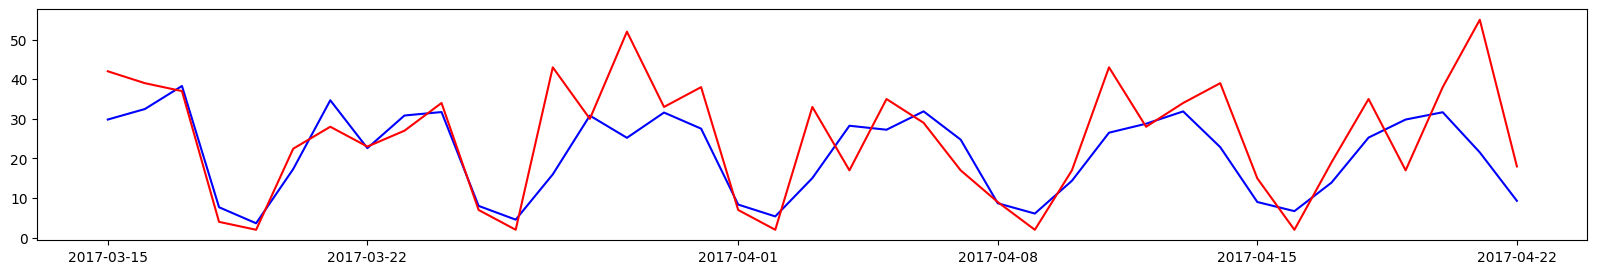

In [26]:
plt.figure(figsize=(20,3))
plt.plot(pred_reversed, 'blue')
plt.plot(val.loc[:, id], 'red')

## Scale - build model / predict for all IDs

In [31]:
for i, id in enumerate(pred_ids):
    
    if Path(f'model/{id}.sav').is_file():
        print(f'{id}.sav exists')
        continue
    
    else:
        print(f'working on id {i+1}/{len(pred_ids)} ({id})')
        ts = np.log1p(train.loc[:, id])
        model = pm.auto_arima(
            ts,
            start_p=1, max_p=439,
            start_q=1, max_q=10,
            # trace=True,
        )
        pickle.dump(model, open(f'model/{id}.sav', 'wb'))
        
        pred = model.predict(val.shape[0])
        pred.dropna().to_csv(f'pred/{id}.csv')
    
    if i == 10:
        break
            
    

air_00a91d42b08b08d9.sav exists
air_0164b9927d20bcc3.sav exists
air_0241aa3964b7f861.sav exists
air_0328696196e46f18.sav exists
air_034a3d5b40d5b1b1.sav exists
air_036d4f1ee7285390.sav exists
air_0382c794b73b51ad.sav exists
air_03963426c9312048.sav exists
air_04341b588bde96cd.sav exists
air_049f6d5b402a31b2.sav exists
air_04cae7c1bc9b2a0b.sav exists
air_0585011fa179bcce.sav exists
air_05c325d315cc17f5.sav exists
air_0647f17b4dc041c8.sav exists
air_064e203265ee5753.sav exists
air_066f0221b8a4d533.sav exists
air_06f95ac5c33aca10.sav exists
air_0728814bd98f7367.sav exists
air_0768ab3910f7967f.sav exists
air_07b314d83059c4d2.sav exists
air_07bb665f9cdfbdfb.sav exists
air_082908692355165e.sav exists
air_083ddc520ea47e1e.sav exists
air_0845d8395f30c6bb.sav exists
air_084d98859256acf0.sav exists
air_0867f7bebad6a649.sav exists
air_08ba8cd01b3ba010.sav exists
air_08cb3c4ee6cd6a22.sav exists
air_08ef81d5b7a0d13f.sav exists
air_08f994758a1e76d4.sav exists
air_09040f6df960ddb8.sav exists
air_0919

In [33]:
rmsle = []
error_ids = []

for i, id in enumerate(pred_ids):
    pred = pd.read_csv(f'pred/{id}.csv', names=['date', 'visitors'])
    pred_reversed = np.expm1(pred.dropna().visitors)
    try: 
        error = mean_squared_log_error(val.loc[:, id], pred_reversed)
        rmsle.append(error)
    
    except ValueError:
        error_ids.append(id)
        continue

In [34]:
error_ids

['air_105a7954e32dba9b',
 'air_2545dd3a00f265e2',
 'air_68cc910e7b307b09',
 'air_a9a380530c1e121f']

In [36]:
np.mean(rmsle)

0.3381103860655536